In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import random

class template_generator:
    def __init__(self,MotorUnits,Radius):
        self.duration=1
        self.sampling_rate=100000
        self.t=np.arange(0,self.duration+1/self.sampling_rate,1/self.sampling_rate)
        self.MotorUnits=MotorUnits
        self.Radius=Radius
        
    def sfap(self,fibre,NMJ,cv,z,sigr,Ka,h,start):
        delta_length=0.05
        zz=np.arange(0,fibre+delta_length,delta_length)
        cv=cv*1000
        t=self.t[0:5000]
        b=7
        a=b*0.303
        P2=-0.108
        P3=-P2*a/b
        P1=-(P3+P2)

        P=np.array([P1,P2,P3,P3,P2,P1]).reshape(-1,1)
        Pz=np.array([NMJ,NMJ,NMJ,NMJ,NMJ,NMJ]).reshape(-1,1)
        Pzi=np.zeros((len(Pz),len(t)))

        Pzi[0]=NMJ
        Pzi[5]=NMJ
        Pzi[0,start:]=Pz[0]+cv*t[0:len(t)-start]
        Pzi[5,start:]=Pz[5]-cv*t[0:len(t)-start]
        i = min(range(len(Pzi[0])), key=lambda i: abs(Pzi[0][i] - (NMJ+a)))
        j = min(range(len(Pzi[5])), key=lambda i: abs(Pzi[5][i] - (NMJ-a)))
        Pzi[1]=NMJ
        Pzi[1,i:len(t)]=Pz[1]+cv*t[0:len(t)-i]
        Pzi[4]=NMJ
        Pzi[4,j:len(t)]=Pz[4]-cv*t[0:len(t)-j]
        i = min(range(len(Pzi[0])), key=lambda i: abs(Pzi[0][i] - (NMJ+b)))
        j = min(range(len(Pzi[5])), key=lambda i: abs(Pzi[5][i] - (NMJ-b)))
        Pzi[2]=NMJ
        Pzi[2,i:len(t)]=Pz[2]+cv*t[0:len(t)-i]
        Pzi[3]=NMJ
        Pzi[3,j:len(t)]=Pz[3]-cv*t[0:len(t)-j]

        Pzi[Pzi<0]=zz[0]
        Pzi[Pzi>fibre]=zz[-1]
        Pi = np.tile(P, (1, len(t)))
        np.set_printoptions(threshold=np.inf) 
        EMatrix = np.zeros((len(t)))  
        EMatrix =-np.sum((1 / (2 * np.pi * sigr))*(Pi / np.sqrt((h ** 2)*Ka + ((NMJ+z - Pzi) ** 2))), axis=0)
        return EMatrix
    
    def muap(self,N,R0,h0,fibre,ExtZ,InnZ,NMJ0,z1,x,y):
        R = np.full(N, R0)
        theta = np.linspace(0, 2*np.pi,N)
        eta = np.linspace(0, 1,N)
        h_eta = np.sqrt((R*eta*np.sin(theta)+x)**2+(y+h0-R*eta*np.cos(theta))**2)
        delta_length = 0.05
        zz = np.arange(0, fibre+delta_length, delta_length)
        t=self.t[0:5000]
        WTRs = np.random.uniform(zz[-1]-ExtZ/2, zz[-1]+ExtZ/2, size=N)
        WTLs = np.random.uniform(zz[0]-ExtZ/2, zz[0]+ExtZ/2, size=N)
        NMJs = np.random.uniform(-(InnZ/2), (InnZ/2), size=N)
        fibrelengths = WTRs - WTLs
        start = np.random.randint(0,5/0.01, size=N)
        OneMU1 = np.zeros((len(t)))

        for i in range(N):
            NMJss = NMJ0 + NMJs[i]
            z_1=NMJ0+z1-NMJss
            OneFibre1 = self.sfap(fibrelengths[i],NMJss-WTLs[i],4,z_1,0.33,6,h_eta[i],start=start[i])
            OneMU1 = OneMU1 + OneFibre1
            zeros=len(self.t)-len(t)

        return np.pad(OneMU1,(0,zeros),mode='constant')
    
    
    def muap_pool(self,N,R2):
        muaps_pool={}

        theta=np.linspace(0,2*np.pi,100)
        x_R2=R2*np.cos(theta)
        y_R2=R2-R2*np.sin(theta)

        plt.figure(figsize=(6,4))
        plt.plot(x_R2,y_R2,color='red')
        plt.title('Motor Units in Muscle')   
        x=np.zeros(N)
        y=np.zeros(N)

        for i in range(N):
            angle = random.uniform(0, 2*np.pi)
            R_eta = random.uniform(0, R2)
            x[i]=R_eta*np.cos(angle)
            y[i]=R2-R_eta*np.sin(angle)
        plt.scatter(x,y,marker='o')
        for i in range(N):
            plt.text(x[i], y[i], f'MU{i+1}', ha='center', va='bottom')

        r=pow(2000,1/N)
        for i in range(N):
            No_of_fibres=100+r**(i+1)
            R1=np.sqrt(No_of_fibres/(20*np.pi))
            theta_r=np.linspace(0,2*np.pi,100)
            x_r=x[i]+R1*np.cos(theta_r)
            y_r=y[i]-R1*np.sin(theta_r)
            plt.plot(x_r,y_r,color='red')
            muaps_pool[i]=self.muap(int(No_of_fibres),R1,10,210,10,5,120,70,x[i],y[i])
        return muaps_pool
    
    
    def plot(self,muap_templates):
        plt.figure(figsize=(8,4))
        for i in range(4):
            plt.plot(self.t[0:5000],self.sfap(210,120,4,20*i,0.33,6,10,start=0))
        plt.xlabel('Time(s)')
        plt.ylabel('Amplitude(Volts)')
        plt.title('Action Potential of a Single Fibre recorded at different positions')
        legends=['z=0','z=20','z=40','z=60']
        plt.legend(legends)
        plt.axhline()
        plt.grid()
        plt.xlim(0,0.035)

        plt.figure()
        fig,axes=plt.subplots(6,figsize=(4,12))
        axes=axes.flatten()
        for i in range(0,6):
            axes[i].plot(self.t,self.muap(100,1,10,210,10,5,120,-10+i*20,0,0))
            axes[i].legend([f"z = {-10+i*20}"])
            axes[i].set(xlabel="Time (s)")
            axes[i].axhline()
            axes[i].grid()
            axes[i].set_xlim(0,0.05)
        plt.suptitle('Action Potential of a Motor Unit recorded at different positions')
        plt.show()

        plt.figure(figsize=(8,4))
        for i in range(self.MotorUnits):
            plt.plot(self.t,muap_templates[i])

        plt.axhline()
        plt.xlim(0,0.050)
        plt.grid()
        plt.xlabel('Time(s)')
        plt.ylabel('Potential')
        plt.title('Different Motor Unit Action Potentials seen at Skin Surface')
        legends=['MU1','MU2','MU3','MU4','MU5','MU6','MU7','MU8','MU9','MU10']
        plt.legend(legends)

    def template_generation(self):
        muap_template = self.muap_pool(self.MotorUnits,self.Radius)
        self.plot(muap_template)
        return muap_template
    

class EMGSimulator:
    def __init__(self,E,muap_templates,muap_template_1):
        self.E_slope=E/1
        self.duration=muap_templates.duration
        self.sampling_rate=muap_templates.sampling_rate
        self.t=np.arange(0,self.duration+1/self.sampling_rate,1/self.sampling_rate)
        self.E_drive=self.E_slope*self.t
        self.E_value=self.E_slope*self.duration
        self.Rthr={}
        self.fr={}
        self.muap_templates_1=muap_template_1
        self.MotorUnits=len(muap_template_1)
        self.Radius=muap_templates.Radius

        for i in range(self.MotorUnits):
            self.Rthr[i]=[np.exp(np.log(30)*(i+1)/self.MotorUnits)]
            Min_fr=8
            peak_fr=45-10*self.Rthr[i][0]/30
            self.fr[i]=[Min_fr,peak_fr]
            self.Rthr[i].append(self.Rthr[i][0]+(peak_fr-Min_fr)/1)

    
    def calculate_firing_rates(self):
        firing_rates = {}
        for motor_unit in self.Rthr.keys():
            firing_rates[motor_unit] = np.zeros_like(self.t)
            min_E, max_E = self.Rthr[motor_unit]
            for i, E in enumerate(self.E_drive):
                if E <= min_E:
                    firing_rates[motor_unit][i] = self.fr[motor_unit][0]
                elif E > max_E:
                    firing_rates[motor_unit][i:] = self.fr[motor_unit][1]
                    break
                else:
                    firing_rates[motor_unit][i] = 1*(E-self.Rthr[motor_unit][0])+self.fr[motor_unit][0]
        return firing_rates
    
    def generate_spike_trains(self,firing_rates):
        spike_trains = {}
        for motor_unit in firing_rates.keys():
            spike_trains[motor_unit] = np.zeros_like(self.t)
            for i, rate in enumerate(firing_rates[motor_unit]):
                spike_trains[motor_unit][i] = poisson.rvs(rate/self.sampling_rate)  # convert rate from Hz to spikes per sample
        return spike_trains

    def generate_emg(self,spike_trains,muap_templates):
        muaps = {}
        for motor_unit, spike_train in spike_trains.items():
            muap_i = np.zeros_like(self.t)
            for i, spike in enumerate(spike_train):
                if spike:
                    start = i
                    end = start + len(muap_templates[motor_unit])
                    if end > len(muap_i):
                        end = len(muap_i)
                        muap_i[start:end] += muap_templates[motor_unit][:end-start]
                    else:
                        muap_i[start:end] += muap_templates[motor_unit]
            muaps[motor_unit] = muap_i
        emg = np.zeros_like(self.t)
        for muap_i in muaps.values():
            emg += muap_i
        return emg,muaps
    
    def plot(self,firing_rates,spike_trains,emg,muaps):

        plt.figure(figsize=(8,4))
        for i in range(self.MotorUnits):
            plt.plot(self.t,firing_rates[i])
        plt.title('Firing Rates of MotorUnits in Muscle')
        legends=['MU1','MU2','MU3','MU4','MU5','MU6','MU7','MU8','MU9','MU10']
        plt.legend(legends)

        plt.figure(figsize=(6,4))
        for motor_unit, spike_train in spike_trains.items():
            plt.eventplot(np.where(spike_train)[0]/self.sampling_rate, lineoffsets=motor_unit)
        plt.xlabel("Time (s)")
        plt.ylabel("Motor Unit")
        plt.yticks(list(spike_trains.keys()))
        plt.title("Spike Train of MotorUnits in Muscle")
        plt.grid(True)

        plt.figure(figsize=(8,4))
        for i in range(self.MotorUnits):
            plt.plot(self.t,muaps[self.MotorUnits-i-1],label=f"MU{self.MotorUnits-i}")
        plt.title('Motor Unit Recruitment in Muscle')
        plt.xlabel('Time(s)')
        plt.ylabel('Amplitude(Volts)')
        plt.legend()

        plt.figure(figsize=(8,4))
        plt.plot(self.t,emg)
        plt.xlabel('Time(s)')
        plt.ylabel('Amplitude(Volts)')
        plt.title('SEMG Signal')

    def run_simulation(self):
        firing_rates=self.calculate_firing_rates()
        spike_trains=self.generate_spike_trains(firing_rates)
        emg,muaps=self.generate_emg(spike_trains,self.muap_templates_1)
        self.plot(firing_rates,spike_trains,emg,muaps)
        
        return emg,muaps
    

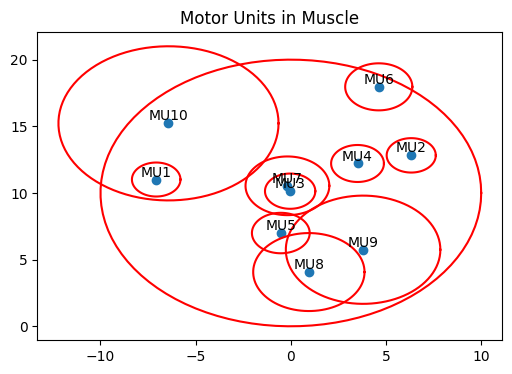

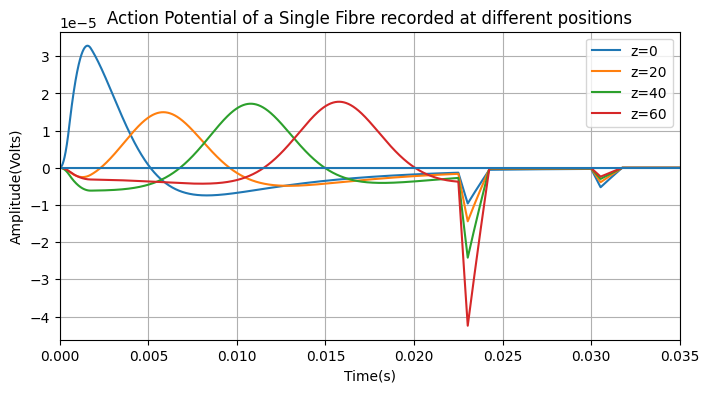

<Figure size 640x480 with 0 Axes>

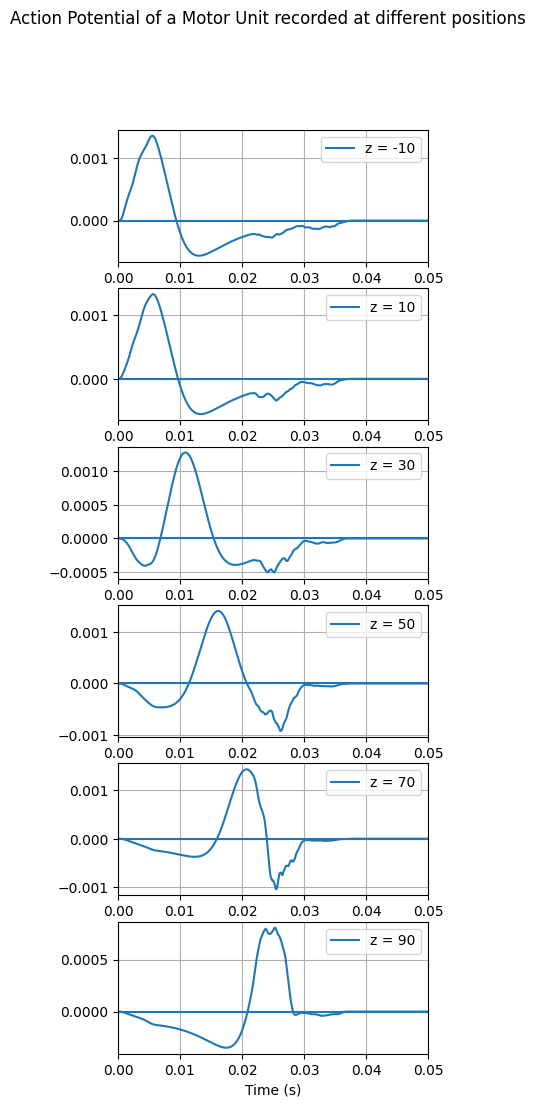

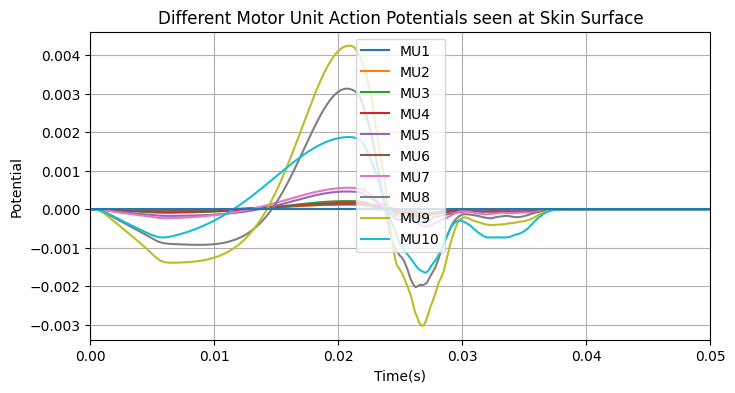

In [17]:
muap_templates = template_generator(10,10)
muap_template=muap_templates.template_generation()

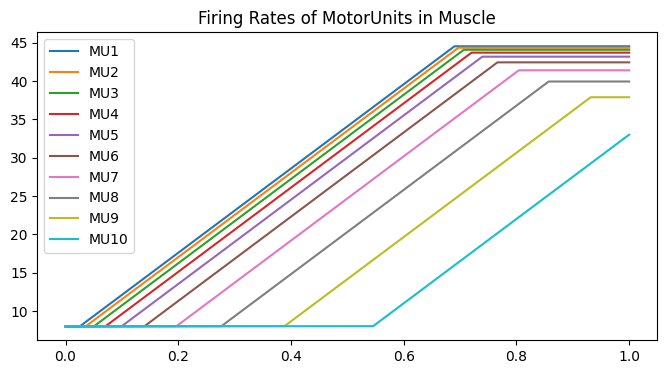

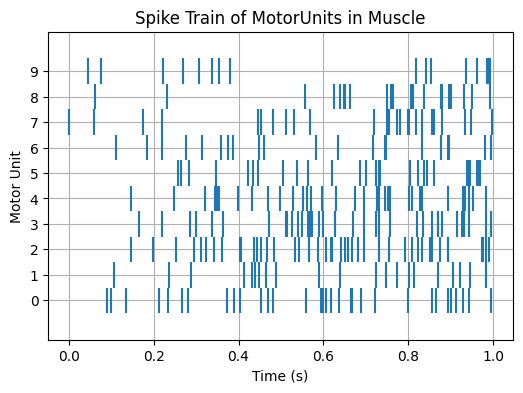

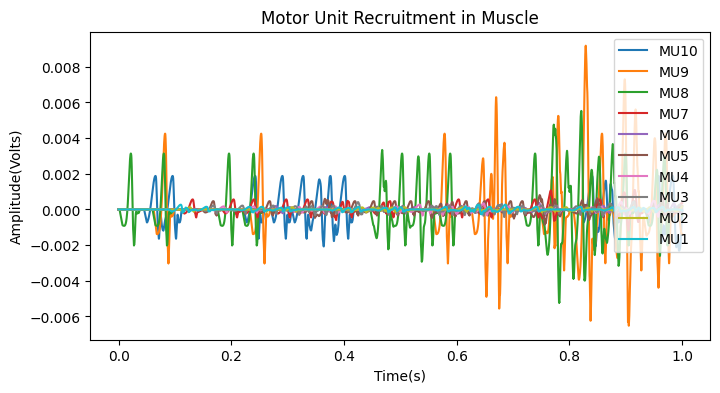

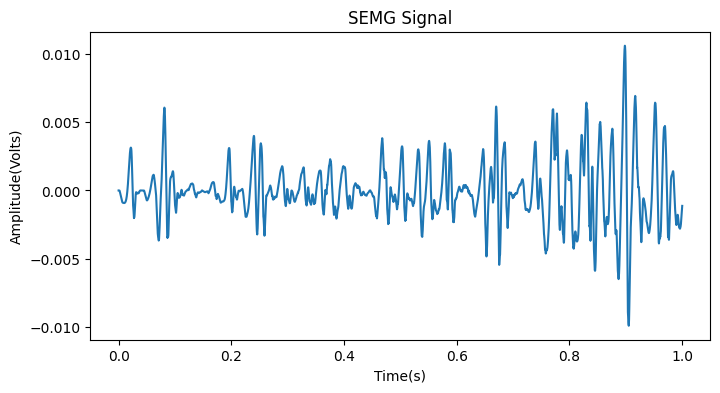

In [20]:
simulator = EMGSimulator(55,muap_templates,muap_template)
emg,muaps =simulator.run_simulation()